In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt

import numpy as np

from Utils.models import *
from Utils.simulation import *
from Utils.plot_utils import *

import time
from copy import copy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we define some basics

In [10]:
import json

# Create a dictionary to store the parameters
params_dict = {
    "dataset_parameters": {
        "n_samples": 200
    },
    "network_parameters": {
        "input_size": 2**6,
        "hidden_size": 2**7,
        "output_size": 1,
        "bias": 1,
    },
    "training_parameters": {
        "num_epochs": 50,
        "learning_rate": 0.1
    },
    "simulation_parameters": {
        "mu": 1,
        "sigma": 0.1,
        "theta": 0.5,
        "dt": 0.001
    },
    "seed": 42
}

# Save the dictionary as a JSON file
# with open('simulation_parameters.json', 'w') as json_file:
#     json.dump(params_dict, json_file, indent=4)
rng = random.key(params_dict["seed"])

In [11]:
mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])

sigma_LN

Array(0.10025112, dtype=float32, weak_type=True)

In [12]:
rng, net_key = random.split(rng)
params = init_mlp(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])
W_h_init = copy(params['W_h'])

We create a stupid dataset made of binary arrays to be matched with a binary output.

In [13]:
rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key, n_samples=params_dict["dataset_parameters"]["n_samples"], input_dim=params_dict["network_parameters"]["input_size"])

In [14]:


loss_list = []
acc_list = []

train_weights_lists = {'W_i': [], 'W_h': [], 'W_o': []}

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in zip(X_train,y_train):

        rng, gou_key = random.split(rng)

        grads = grad(loss)(params, x, y)
        params['W_i'] -= learning_rate*grads['W_i']
        params['W_h'] -= learning_rate*grads['W_h']-perturb_GOU(gou_key, params['W_h'],  **simulation_parameters )
        params['W_o'] -= learning_rate*grads['W_o']



        # params['W_h'] += perturb_GOU(gou_key, params['W_h'],  **simulation_parameters )
        #

        train_weights_lists['W_i'].append(params['W_i'])
        train_weights_lists['W_h'].append(params['W_h'])
        train_weights_lists['W_o'].append(params['W_o'])

    acc_list.append(accuracy(params, X_train, y_train))
    loss_list.append(loss(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss(params, X_train, y_train)
        train_acc = accuracy(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))


for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in zip(X_train,y_train):


        rng, gou_key = random.split(rng)
        params['W_h'] += perturb_GOU(gou_key, params['W_h'],  **simulation_parameters )

    acc_list.append(accuracy(params, X_train, y_train))
    loss_list.append(loss(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss(params, X_train, y_train)
        train_acc = accuracy(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))

Epoch 0 in 4.65 sec
Training set loss 0.6902629137039185
Training set accuracy 0.5600000023841858
Epoch 10 in 2.09 sec
Training set loss 0.300931453704834
Training set accuracy 0.8849999904632568
Epoch 20 in 2.10 sec
Training set loss 0.04707525297999382
Training set accuracy 0.9899999499320984
Epoch 30 in 2.09 sec
Training set loss 0.0432303324341774
Training set accuracy 0.9950000047683716
Epoch 40 in 2.28 sec
Training set loss 0.02021213434636593
Training set accuracy 1.0
Epoch 0 in 0.16 sec
Training set loss 0.04594077169895172
Training set accuracy 0.9950000047683716
Epoch 10 in 0.16 sec
Training set loss 0.284755140542984
Training set accuracy 0.8849999904632568
Epoch 20 in 0.16 sec
Training set loss 0.6598426699638367
Training set accuracy 0.6649999618530273
Epoch 30 in 0.15 sec
Training set loss 0.8280384540557861
Training set accuracy 0.5349999666213989
Epoch 40 in 0.14 sec
Training set loss 0.8015483021736145
Training set accuracy 0.5349999666213989


In [15]:
    # plot predictions vs true values
y_pred = forward(params, X_train)
# print with 1 significant digit
print(np.round(y_pred- y_train, 1).flatten())



[ 1.         -0.          1.         -0.         -0.         -0.
 -0.         -0.          1.         -0.          1.         -0.
 -0.          1.          0.90000004 -0.         -0.         -0.
 -0.         -0.          1.         -0.          1.         -0.
 -0.          1.          1.          0.90000004  1.          1.
 -0.         -0.          1.          1.          1.         -0.
  1.         -0.         -0.          1.         -0.         -0.
  1.         -0.         -0.1         1.         -0.         -0.
  1.         -0.          1.          1.          1.          1.
  1.         -0.          1.         -0.         -0.         -0.
 -0.         -0.          1.          1.         -0.         -0.1
  1.          1.         -0.          1.          1.          1.
 -0.          0.90000004 -0.         -0.          1.          1.
 -0.         -0.          1.         -0.         -0.1        -0.
  1.         -0.          1.          1.          1.         -0.
 -0.         -0.        

In [59]:
train_weights_lists['W_h'] = np.array(train_weights_lists['W_h']).reshape(num_epochs*params_dict["dataset_parameters"]["n_samples"], -1)
train_weights_lists['W_i'] = np.array(train_weights_lists['W_i']).reshape(num_epochs*params_dict["dataset_parameters"]["n_samples"], -1)
train_weights_lists['W_o'] = np.array(train_weights_lists['W_o']).reshape(num_epochs*params_dict["dataset_parameters"]["n_samples"], -1)


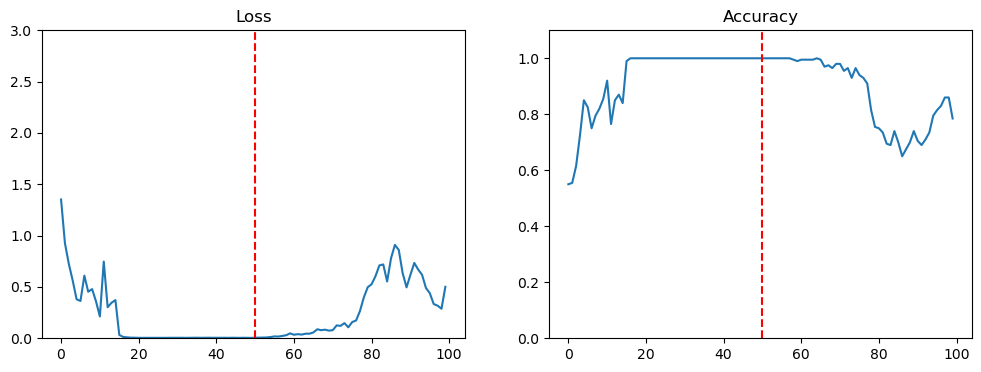

In [58]:

#plot the loss and accuracy in 2 subplots

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.ylim([0, 3])
plt.title('Loss')
plt.axvline(x=num_epochs, color='r', linestyle='--')
plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.ylim([0, 1.1])
plt.title('Accuracy')
#draw a vertical line at the end of the training
plt.axvline(x=num_epochs, color='r', linestyle='--')

plt.savefig("loss_acc_test.png")
plt.show()

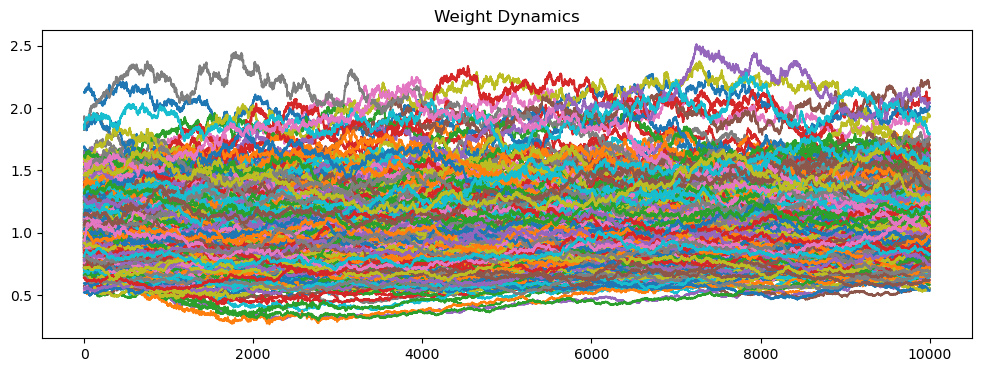

In [60]:

#plot weight dynamics
name = "W_h"

plot_weight_dynamics(train_weights_lists[name], "Weight Dynamics", weights_to_show=600)
#plot_weight_dynamics(train_weights_lists[name], "Weight Dynamics", weights_to_show=500, log=True)


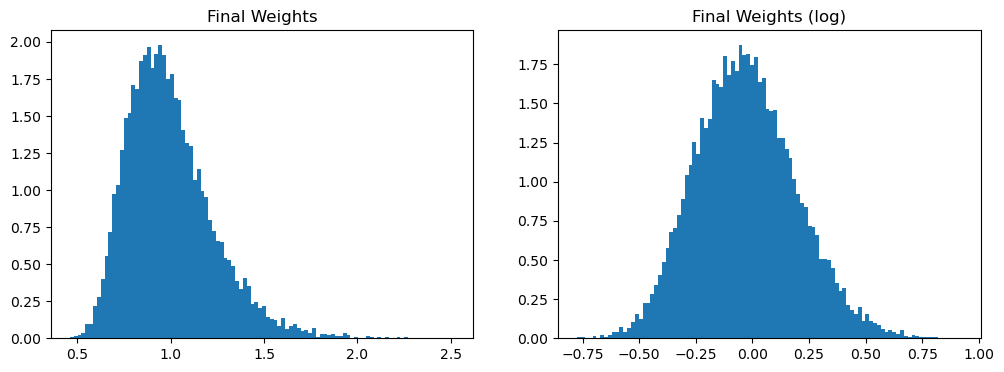

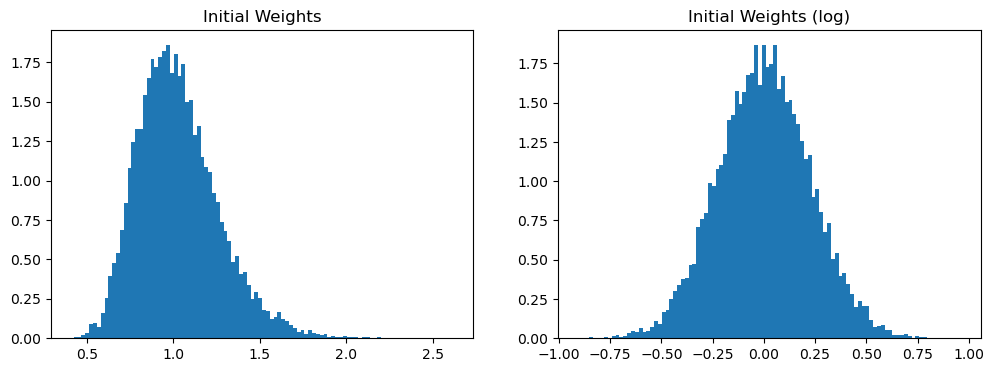

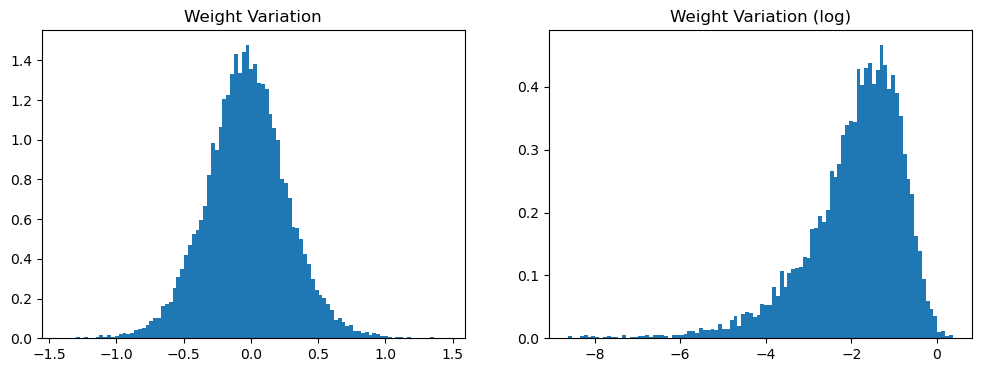

In [61]:
plot_weights(params['W_h'], "Final Weights")
# initial weights
plot_weights(W_h_init, "Initial Weights")

delta = params['W_h'] - W_h_init

plot_weights(delta, "Weight Variation")

# EIGENVLAUES
---------------------------------------------

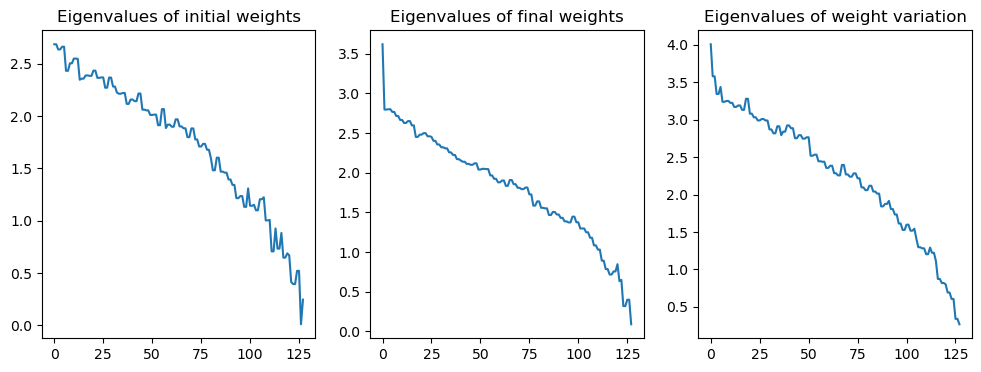

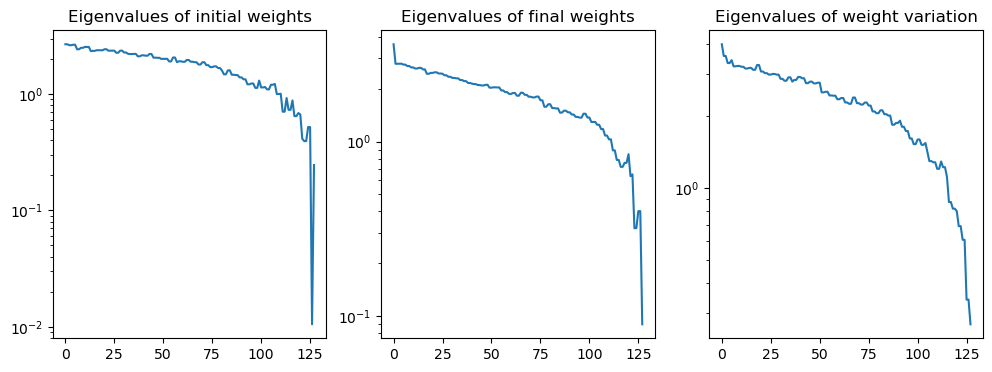

In [62]:
plot_eigenvalues(params['W_h'], W_h_init, bias = params_dict["network_parameters"]["bias"], log=False)
plot_eigenvalues(params['W_h'], W_h_init, bias = params_dict["network_parameters"]["bias"], log=True)

In [12]:
# check the initial weights dynamics with no learning

rng, pert_key = random.split(rng)
W_h_perturb = copy(W_h_init)

perturbed_weight_list = simulate_perturbation_only(pert_key,
                                         W_h_perturb,
                                         n_steps=num_epochs*len(X_train),
                                        **simulation_parameters)


final_weights = perturbed_weight_list[-1]

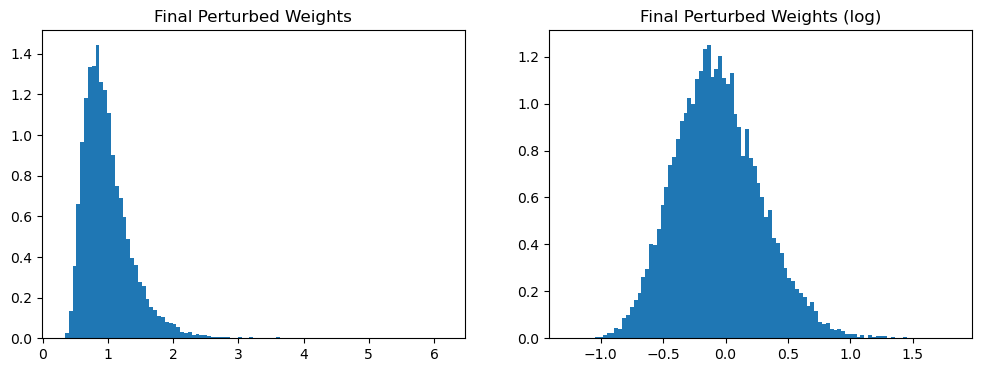

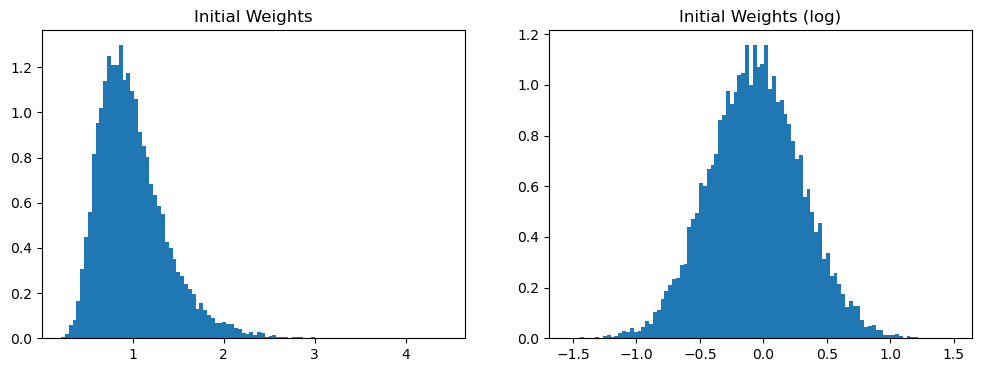

In [13]:
plot_weights(final_weights, "Final Perturbed Weights")

plot_weights(W_h_init, "Initial Weights")

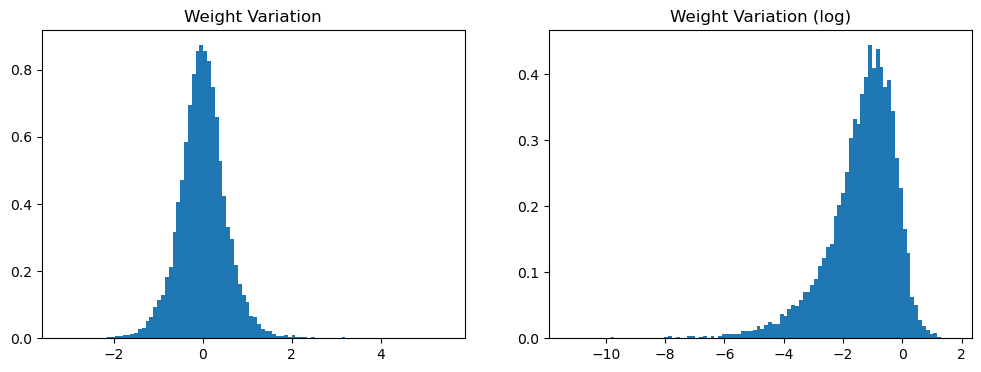

In [19]:
plot_weights(final_weights - W_h_init, "Weight Variation")

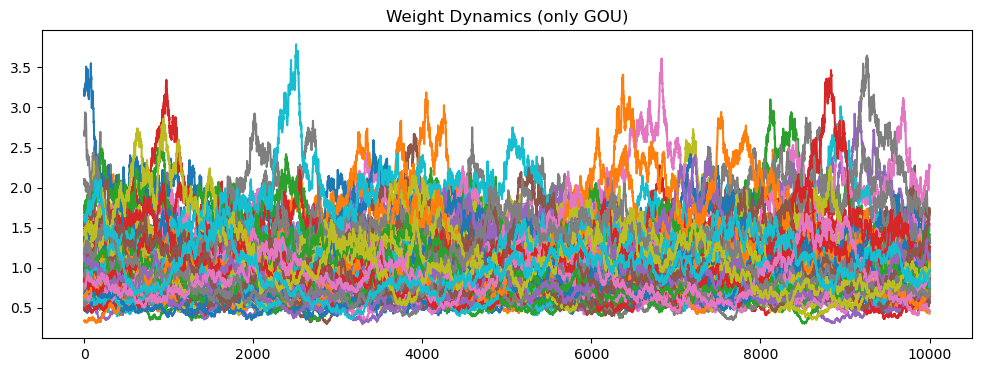

In [14]:
plot_weight_dynamics(perturbed_weight_list.reshape(perturbed_weight_list.shape[0], -1), "Weight Dynamics (only GOU)")

In [ ]:
W_h_init.mean()

In [ ]:
final_weights.mean()

In [ ]:
W_h_init.var()

In [ ]:
final_weights.var()
